# Ordinal Regression Concepts and Computational Methods
## Eric Beckwith

In [1]:
#Load required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import inf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import add_dummy_feature
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()  
encoder = LabelEncoder()
import warnings
np.seterr(over='ignore')
np.seterr(divide='ignore', invalid='ignore')
from IPython.display import display
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
pd.options.display.max_rows = 4000

# Cumulative Logit model

We can define the cumulative logit as:
$$\operatorname { logit } [ P ( Y \leq j ) ] = \log \frac { P ( Y \leq j ) } { 1 - P ( Y \leq j ) }$$

This logit equals the ordinary binary logit applied to the collapsing of the response outcomes into the two results Y < j and Y > j . Each cumulative logit uses all c response categories.  Introducing explanatory variables, we obtain the cumulative logit model:

$$\operatorname { logit } [ P ( Y \leq j ) ] = \alpha _ { j } + \boldsymbol { \beta } ^ { \prime } \mathbf { x }$$

The common effect Beta for the cumulative logits here implies that the response curves for the cumulative probabilities all have the same shape, just shifted- this is why this model is also commonly as referred to as proportional odds.

In it's simplest form, we can apply this model by hand to a contingency table of data to look at the interpretations.  In the table below, we see the resuts of a 2006 General Social Survey which asked subjects, "Would you say that astrology is very scientific, sort of scientific, or not at all scientific?" (Agresti, 2010)

In [2]:
#Astrology data
ast = pd.read_csv('data/Astrology.csv').reset_index().set_index('Degree')
ast.index =  ['<High School', 'High School', 'Junior College', 'Bachelors', 'Graduate']
display (ast)
#Prepare Astrology data
ast['Row_total'] = ast.sum(axis=1)
#compute percentages of total for each 
ast.Very = ast.Very / ast.Row_total
ast.Sort_of = ast.Sort_of / ast.Row_total
ast.Not_at_all = ast.Not_at_all / ast.Row_total
#add columns for the cumulative logits
ast['CL1'] = np.log(ast.Very / (ast.Sort_of + ast.Not_at_all))
ast['CL2'] = np.log((ast.Very + ast.Sort_of) / (ast.Not_at_all))
#for each education category, assign dummies for each of the 2 intercepts here
ast_X = np.array([[0,1,0], [1,1,0], [2,1,0], [3,1,0], [4,1,0],
             [0,0,1], [1,0,1], [2,0,1], [3,0,1], [4,0,1]])
#stack the two cumulative logits to do 1 regression
ast_y = pd.concat((ast.CL1, ast.CL2)).reset_index(drop=True)
results1 = sm.OLS(ast_y,ast_X).fit()
display (results1.summary())

,index,Very,Sort_of,Not_at_all
<High School,0,23,84,98
High School,1,50,286,574
Junior College,2,4,44,122
Bachelors,3,11,57,268
Graduate,4,1,23,148


/home/eric/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     80.91
Date:                Thu, 29 Nov 2018   Prob (F-statistic):           1.45e-05
Time:                        00:50:57   Log-Likelihood:                -2.4946
No. Observations:                  10   AIC:                             10.99
Df Residuals:                       7   BIC:                             11.90
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5669      0.083     -6.830      0.000      -0.763      -0.371
x2            -2.2996      0.235     -9.797      0.000      -2.855      -1.745
x3             0.2195      0.235      0.935      0.381      -0.336       0.775
==============================================================================
Omnibus:                        0.552   Durbin-Watson:                   2.734
Prob(Omnibus):                  0.759   Jarque-Bera (JB):                0.029
Skew:                           0.113   Prob(JB):                        0.985
Kurtosis:                       2.861   Cond. No.                         6.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So we obtain a beta coefficient of -0.567 and two intercepts of -2.3 and 0.22.  This beta reflects how the cumulative probability of highly scientific astrology decreases as the education level increases.  Another words, for each level of increase in education we have a multiplicative impact of $e^{-0.567} = 0.567$ in the estimated odds of the response levels.
Now that we have some basics of proportional odds and interpretation of coefficients, we can look at extensions to multiple explanatory variables and larger dataset where calculations of every probability by hand are impossible.

## Datasets

All of the datasets for testing below are taken from the UCI repository, with the exception of the Boston housing dataset which is included in the python datasets.  With the exception of the wine datasets, I have resegmented any data with >5 classes back down to 5 classes.  I also include a synthetically created multiclass dataset, which I have forced into an ordinal pattern.
As a preliminary metric for the 'ordinal-ness' I calculate a NMI, Non-monotonicity index (Milstein et al., 2014), which is a measure of the percentage of pairs of data where the class label is greater but the features data is not similarly increasing.  I modify this slightly to relax the measurement and try to normalize over varying numbers of features and account for levels of monotonocity - instead of a hard 1 or 0, I look at a percentage of the features not increasing.  This metric is still a bit suspect, especially for data like Wiki where the explainatory variables are binary 1/0 instead of continuous.

Note for all testing I use Mean Absolute Error as the metric.  This helps take into the account that unlike in multiclass where we are indifferent to the classes, in ordinal cases missing by one class is preferable to missing by more than one.

In [3]:
#Import all datasets for testing and scale them
#https://archive.ics.uci.edu/ml/datasets.html
#abalone
abalone = pd.read_csv('data/abalone.data', header=None)
abalone.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_Wgt', 'Shucked_Wgt',
                      'Visc_Wgt', 'Shell_Wgt', 'Rings']
abalone_X = pd.concat((abalone.loc[:,'Length':'Shell_Wgt'], 
                       pd.get_dummies(abalone.Sex, prefix="Sex", drop_first=True)), axis=1)
abalone_y = abalone.Rings
abalone_y = pd.qcut(abalone.Rings, 5, labels=False)

#White wine
wwine = pd.read_csv('data/winequality-white.csv', sep=';')
wwine_X = wwine.loc[:,:'alcohol']
wwine_y = wwine.quality
#red wine
rwine = pd.read_csv('data/winequality-red.csv', sep=';')
rwine_X = rwine.loc[:,:'alcohol']
rwine_y = rwine.quality

#Wikipedia
#PU2: The use of Wikipedia improves students' learning 
#PU3: Wikipedia is useful for teaching 
#PU1: The use of Wikipedia makes it easier for students to develop new skills 
wiki = pd.read_csv('data/wiki4HE.csv', sep=';')
wiki = wiki.loc[(wiki.YEARSEXP!='?') & (wiki.DOMAIN!='?') & (wiki.PU1!='?') &\
                (wiki.PU2!='?') & (wiki.PU3!='?') & (wiki.USERWIKI!='?'),:].reset_index(drop=True)
wiki_X = wiki.loc[:, :'UNIVERSITY'].astype(int)
wiki_X['WIKI_USER'] = wiki.USERWIKI
wiki_X.UNIVERSITY-=1
wiki_X = pd.concat((wiki_X,pd.get_dummies(wiki_X.DOMAIN, prefix='DOMAIN', drop_first=True)), axis=1)
wiki_X.drop('DOMAIN', axis=1, inplace=True)
wiki2_X = wiki_X.copy()
wiki3_X = wiki_X.copy()
wiki_y = wiki.PU1.astype(int)
wiki2_y = wiki.PU2.astype(int)
wiki3_y = wiki.PU3.astype(int)

#Boston housing
from sklearn.datasets import load_boston, fetch_california_housing
boston = load_boston()
boston_X = boston.data
boston_y = pd.qcut(boston.target, 5, labels=False)

#synthetic data ordinal
syn_X = np.random.rand(200,10)
syn_X = np.append(syn_X, syn_X + np.random.rand(200,10)-0.25, axis=0)
syn_X = np.append(syn_X, syn_X[-200:,:] + np.random.rand(200,10)-0.2, axis=0)
syn_X = np.append(syn_X, syn_X[-200:,:] + np.random.rand(200,10)-0.35, axis=0)
syn_X = np.append(syn_X, syn_X[-200:,:] + np.random.rand(200,10)-0.3, axis=0)
syn_y = np.append(np.append(np.append(np.append(np.zeros(200), np.ones(200)),\
                                      np.ones(200)*2), np.ones(200)*3),np.ones(200)*4)

datasets = ['abalone', 'wwine', 'rwine', 'wiki', 'wiki2', 'wiki3', 'boston', 'syn']

In [4]:
#Container for ordinal model data and fits
class OrdinalModel:
    def __init__(self, X, y, X_test, y_test):
        self.X = np.array(X)               # training data
        self.y = np.array(y)               # class labels
        self.X_test = np.array(X_test)               # training data
        self.y_test = np.array(y_test)               # class labels
        self.k = len(np.unique(y))  # number of classes
        self.n = len(self.X)        # length of training set
        self.nt = len(self.X_test)        # length of test set
        self.theta = np.zeros(self.k)       # thresholds
        self.beta = np.zeros(self.X.shape[1]+1)         # coeffiecients
        self.pred_y = np.zeros(self.k)     # class predictions
        self.pred_prob_y = np.zeros((self.nt,self.k))     # class predictions        
        self.MAE = 0  # mean absolute error
        self.logloss = 0  #log_loss
    
    def adjust_and_scale(self):
        #scale categories to start at zero and ordered
        #rescale y's to start at zero
        offset = self.y.min()
        self.y-=offset
        self.y_test-=offset
        # make the categories continuous
        self.y = encoder.fit_transform(self.y)
        self.y_test = encoder.transform(self.y_test)
        #scale X's and add an intercept column
        self.X = add_dummy_feature(scaler.fit_transform(self.X))
        self.X_test = add_dummy_feature(scaler.transform(self.X_test))            
        
    #main fitting functions
    def fit(self, kind, link='logistic'):
        if kind=='binary':
            ordinal_by_binary(self, link)
        elif kind=='linreg':
            linreg_to_category(self)
        elif kind=='multiclass':
            logistic_multi(self)
        elif kind=='ovr':
            logistic_ovr(self)
        elif kind=='cumlink':
            run_ll_min(self, link)
        elif kind=='thresh_IT':
            run_thresh_IT(self)
        elif kind=='thresh_AT':
            run_thresh_AT(self)
        elif kind=='NN_ord':
            run_NN(self, ordinal='True')
        elif kind=='NN':
            run_NN(self, ordinal='False')
        else:
            print('Bad model selection')
        #compute MAE
        self.MAE = error_metric(self.pred_y, self.y_test, metric='MAE')

#error metrics function
def error_metric(y_pred, y_true, metric='MAE'):
    if metric=='MAE':
        error=0
        y_pred=np.array(y_pred)
        y_true=np.array(y_true)
        for i in range(0,len(y_pred)):
            error += abs(y_pred[i]-y_true[i])
        error /= len(y_pred)
    elif metric=='log-loss':
        error = log_loss(y_true, y_pred)
    return error       

In [5]:
def get_NMI(model):
    # compute Non-monotonicity index function
    collision = 0
    min_class = min(model.y)
    for i in range(model.n):
        if model.y[i]!=min_class:
            for j in range(model.n):
                #if class greater
                if model.y[i]>model.y[j]:
                    #but explainatory not...
                    collision+=2*((model.X[i,:]<model.X[j,:]).sum())/model.X.shape[1]
    return collision/(model.n*(model.n+1))

#Get NMI for all datasets
nmi_df=[]
for df in datasets:
    X=np.array(globals()[df+"_X"])
    y=np.array(globals()[df+"_y"])
    model = OrdinalModel(X,y,X,y)
    nmi_df.append([df, model.k, model.n, model.X.shape[1] ,get_NMI(model)])
data_summary = pd.DataFrame(nmi_df, columns=['Dataset', 'Classes', '# Samples', '# Features', 'NMI'])
data_summary

,Dataset,Classes,# Samples,# Features,NMI
0,abalone,5,4177,9,0.191370
1,wwine,7,4898,11,0.347499
2,rwine,6,1599,11,0.309211
3,wiki,5,871,11,0.154212
4,wiki2,5,871,11,0.151258
5,wiki3,5,871,11,0.154825
6,boston,5,506,13,0.418823
7,syn,5,1000,10,0.215155


## Decomposing into series of binary classifiers

As a baseline, I include here two primary methods for multi-classification - namely logistic multiclass classification, and classification with binary logistic regression using a one-v-rest methodology.  Also, for ordinal data, a naive approach would be to fit a linear regression model, then force the values back to the nearest category - also included as another benchmark.  I use all these methods (and future in this paper) without regularization.

A further extension would be to consider a similar 'ovr' method using binary classifiers adjusted to the ordinal case.  A method for this was presented in Frank & Hall(2001), in which we fit a series of K-1 binary classifiers to work through the ordinal classes, where for each class value V, the class probability can be computed as:

$$\begin{array} { l } { \operatorname { Pr } \left( V _ { 1 } \right) = 1 - \operatorname { Pr } \left( \text {Target} > V _ { 1 } \right) } \\ { \operatorname { Pr } \left( V _ { i } \right) = \operatorname { Pr } \left( \text {Target} > V _ { i - 1 } \right) - \operatorname { Pr } \left( \text {Target} > V _ { i } \right) , 1 < i < k } \\ { \operatorname { Pr } \left( V _ { k } \right) = \operatorname { Pr } \left( \text {Target} > V _ { k - 1 } \right) } \end{array}$$

For predictions, we similarly need to compute all K-1 classifier values, with the class prediction being specified by the greatest of the set of probabilities.
While this method does not allow for easy interpretation of results, the simplification to binary models allows for the application of a much wider range of possible classifiers with ease - and along with logisitic regression I have included using SVMs with this method in the testing.

In [6]:
#Ordinal with binary and naive linear regression
#prepare all regression model methods solvers
logr = LogisticRegression(fit_intercept=False, solver='lbfgs', max_iter=10000, C=1e7)
logr_m = LogisticRegression(fit_intercept=False, solver='lbfgs', max_iter=10000, C=1e7, multi_class='multinomial')
logr_ovr = LogisticRegression(fit_intercept=False, solver='lbfgs', max_iter=10000, C=1e7, multi_class='ovr')
lr = LinearRegression(fit_intercept=False)
clf = SVC(gamma='auto', probability=True)

def ordinal_by_binary(model, link='logistic'):
    #Frank and Hall (2001)
    y_unique = np.sort(np.unique(model.y))
    probs = np.zeros((len(model.y_test), len(y_unique))).T
    #Do for the first class
    target = model.y>y_unique[0]
    if link=='logistic':
        reg = logr.fit(model.X, y=target)
    elif link=='svm':
        reg = clf.fit(model.X, y=target)
    probs[0] = reg.predict_proba(model.X_test)[:,0]
    #look through the rest of the classes
    for i in range(1,len(y_unique)-1):
        target = model.y>y_unique[i]
        if link=='logistic':
            reg = logr.fit(model.X, y=target)
        elif link=='svm':
            reg = clf.fit(model.X, y=target)
        probs[i] = reg.predict_proba(model.X_test)[:,0] - sum(probs[:i,:])
    #compute final class probability
    probs[i+1] = 1- sum(probs[:i+1,:])
    #find max probability
    preds_log = pd.DataFrame(probs).idxmax()
    #remap to categories
    preds_log = y_unique[preds_log]
    model.pred_y = preds_log
    model.pred_prob_y = probs
    return 0

#Linear regression rounded back to integers in category range
def linreg_to_category(model):
    reg_lr = lr.fit(model.X, model.y)
    preds_lr = np.round(reg_lr.predict(model.X_test),0)
    #make sure we predict in the range
    preds_lr[preds_lr>model.y.max()] = model.y.max()
    preds_lr[preds_lr<model.y.min()] = model.y.min()
    model.pred_y = preds_lr
    model.beta = reg_lr.coef_
    return 0

#Baseline multiclass classifier
def logistic_multi(model):
    reg_lrm = logr_m.fit(model.X, model.y)
    model.beta = reg_lrm.coef_
    model.pred_y = reg_lrm.predict(model.X_test)
    model.pred_prob_y = reg_lrm.predict_proba(model.X_test)
    return 0

#Baseline OVR binary classifier
def logistic_ovr(model):
    reg_ovr = logr_ovr.fit(model.X, model.y)
    model.beta = reg_ovr.coef_
    model.pred_y = reg_ovr.predict(model.X_test)
    model.pred_prob_y = reg_ovr.predict_proba(model.X_test)
    return 0

#Format tables to designate minimum
def format_table(tbl):
    new_tbl=tbl.copy()
    for i in tbl.index:    
        min_col = tbl.loc[i,:].idxmin()
        new_tbl.loc[i,min_col] = str(tbl.loc[i,min_col]) + '*'
    return new_tbl

In [7]:
#Run 5-fold CV on all datasets and base/binary methods
skf = StratifiedKFold(n_splits=5)
results_tbl = [] 
error = 'MAE'
for df in datasets:
    X=np.array(globals()[df+"_X"])
    y=np.array(globals()[df+"_y"])
    res_df = []
    for train_index, test_index in skf.split(X, y):
        df_model = OrdinalModel(X[train_index], y[train_index], X[test_index], y[test_index])
        df_model.adjust_and_scale()
        df_model.fit('multiclass')
        err_lgm=df_model.MAE
        df_model.fit('ovr')
        err_ovr=df_model.MAE
        df_model.fit('linreg')
        err_lr=df_model.MAE
        df_model.fit('binary', 'logistic')
        err_ob=df_model.MAE
        df_model.fit('binary', 'svm')
        err_svm=df_model.MAE
        res_df.append([err_lgm, err_ovr, err_lr, err_ob, err_svm])
    results = pd.DataFrame(res_df).mean()
    results_tbl.append([round(val,3) for val in results])
results_base = pd.DataFrame(results_tbl, index=datasets, columns=['Logistic-Multi', 'Logistic-Ovr',
                            'LinReg Ord', 'Ordinal binary', 'Ord-Bin-SVM']).astype(float)
format_table(results_base)

,Logistic-Multi,Logistic-Ovr,LinReg Ord,Ordinal binary,Ord-Bin-SVM
abalone,0.720,0.745,0.731,0.719,0.677*
wwine,0.540,0.541,0.546,0.545,0.525*
rwine,0.465,0.462,0.446*,0.463,0.45
wiki,1.012,1.020,0.937,1.012,0.9*
wiki2,0.781,0.777,0.741*,0.783,0.761
wiki3,0.826,0.824,0.798*,0.823,0.811
boston,0.538,0.637,0.518*,0.520,0.612
syn,0.415,0.463,0.444,0.406,0.351*


## Cumulative Link model

An alternative method to work with ordinal data in multinomial cases was proposed by McCullagh(1980).   In this model, the observed ordinal response Y is derived from a continuous-valued latent variable by a threshold specification where the latent data are modeled by a regression on covariates.  We can look at the cumulative probablity which yields the likelihood function and it's derivatives listed below.  The initial logit model can be generalized to a variety of link functions.  While the logistic function yields the logit model, using the inverse of the standard normal cdf yields the probit model.  Further links include log-log for survivor data.  These links can be viewed as a representation of the distribution of the underlying latent variables.

For a link function G, Let g denote the derivative of G, that is, the probability density function corresponding to the cdf G.  Delta here denotes the Kronecker delta, 1 if j=k, and 0 othrerwise.

$$L ( \boldsymbol { \alpha } , \boldsymbol { \beta } ) = \sum _ { i = 1 } ^ { n } \sum _ { j = 1 } ^ { c } y _ { i j } \log \left[ G \left( \alpha _ { j } + \boldsymbol { \beta } ^ { \prime } \mathbf { x } _ { i } \right) - G \left( \alpha _ { j - 1 } + \boldsymbol { \beta } ^ { \prime } \mathbf { x } _ { i } \right) \right]$$

$$\frac { \partial L } { \partial \beta _ { k } } = \sum _ { i = 1 } ^ { n } \sum _ { j = 1 } ^ { c } y _ { i j } x _ { i k } \frac { g \left( \alpha _ { j } + \beta ^ { \prime } \mathbf { x } _ { i } \right) - g \left( \alpha _ { j - 1 } + \beta ^ { \prime } \mathbf { x } _ { i } \right) } { G \left( \alpha _ { j } + \beta ^ { \prime } \mathbf { x } _ { i } \right) - G \left( \alpha _ { j - 1 } + \beta ^ { \prime } \mathbf { x } _ { i } \right) }$$

$$\frac { \partial L } { \partial \alpha _ { k } } = \sum _ { i = 1 } ^ { n } \sum _ { j = 1 } ^ { c } y _ { i j } \frac { \delta _ { j k } g \left( \alpha _ { j } + \beta ^ { \prime } \mathbf { x } _ { i } \right) - \delta _ { j - 1 , k } g \left( \alpha _ { j - 1 } + \beta ^ { \prime } \mathbf { x } _ { i } \right) } { G \left( \alpha _ { j } + \beta ^ { \prime } \mathbf { x } _ { i } \right) - G \left( \alpha _ { j - 1 } + \beta ^ { \prime } \mathbf { x } _ { i } \right) }$$

These can be solved through convex minimization algorithms as implemented below.  Unlike the prior methods, here we retain the ability to retrieve coeffiecients for the feature inputs and have far more interpretablity as above.

In [8]:
#Link functions
#Logistic functions
def G_log(z):
    return np.exp(z) / (1.+np.exp(z))

def g_log(z):
    return np.exp(z) / ((1 + np.exp(z))**2)

#Normal functions
def G_norm(Z):
    return norm.cdf(Z)

def g_norm(Z):
    return norm.pdf(Z)

#Smoothed version of hinge function
def smooth_hinge(Z):
    h=Z.copy()
    h = (1-Z)**2/2
    h[Z>=1] = 0
    h[Z<=0] = 0.5 - Z[Z<=0]
    return h

#Constraints for increasing thresholds
def check_thetas(x0, n):
    w, theta_0 = np.split(x0, [n])
    check = theta_0 - np.roll(theta_0,1)
    check[0]=1
    return check

In [9]:
#Log-likelihood and gradient functions

def log_like(x0, X, y, link):
    #log likilihood cumulative link
    w, theta_0 = np.split(x0, [X.shape[1]])
    theta_1 = np.roll(theta_0, 1)
    t0 = theta_0[y]
    theta_1[0] = -99999
    t1 = theta_1[y]
    Xw = X.dot(w)
    if link=='logistic':
        l = -np.log(G_log(t0+Xw) - G_log(t1+Xw))
    elif link=='normal':
        l = -np.log(G_norm(t0+Xw) - G_norm(t1+Xw))
    return np.sum(l)

def grad_w(x0, X, y, link):
    #gradient of feature coefs cum-link
    w, theta_0 = np.split(x0, [X.shape[1]])
    theta_1 = np.roll(theta_0, 1)
    t0 = theta_0[y]
    theta_1[0] = -99999
    t1 = theta_1[y]
    Xw = X.dot(w)
    if link=='logistic':
        l = -X.T * (g_log(t0 + Xw) - g_log(t1 + Xw)) / (G_log(t0 + Xw) - G_log(t1 + Xw)+0.0001)
    elif link=='normal':
        l = -X.T * (g_norm(t0 + Xw) - g_norm(t1 + Xw)) / (G_norm(t0 + Xw) - G_norm(t1 + Xw)+0.001)
    return np.sum(l, axis=1)

def grad_theta(x0, X, y, link):
    #gradient of thresholds cum-link
    w, theta_0 = np.split(x0, [X.shape[1]])
    theta_1 = np.roll(theta_0, 1)
    t0 = theta_0[y]
    theta_1[0] = -99999
    t1 = theta_1[y]
    Xw = X.dot(w)
    loss = np.zeros(len(theta_0))
    i=0
    for k in theta_0:
        if link=='logistic':
            l = -((t0==k)*g_log(t0 + Xw) - (t1==k)*g_log(t1 + Xw)) / (G_log(t0 + Xw) - G_log(t1 + Xw)+0.0001)
        elif link=='normal':
            l = -((t0==k)*g_norm(t0 + Xw) - (t1==k)*g_norm(t1 + Xw)) / (G_norm(t0 + Xw) - G_norm(t1 + Xw)+0.001)
        loss[i] = np.sum(l)
        i+=1
    return loss

def gradient(x0, X, y, link):
    #combine gradients
    g_w = grad_w(x0, X, y, link)
    g_t = grad_theta(x0, X, y, link)
    return np.concatenate((g_w, g_t))

#Run log-lik minimization functions
def run_ll_min(model, link):
    #use LinReg coefs as starting guess for w0
    x0 = lr.fit(model.X,model.y).coef_
    unique_y = np.unique(model.y)
    #generic increasing thetas to start
    theta_start = [0.1*i for i in unique_y]
    x0 = np.append(x0,theta_start)
    #minimize constained on increasing thetas
    results = minimize(log_like, x0, args=(model.X, model.y, link), jac= gradient, method='slsqp', 
                   options={'maxiter':10000},constraints={'type':'ineq', 'fun':check_thetas, 'args':[model.X.shape[1]]})
    model.beta, model.theta = np.split(results.x, [model.X.shape[1]])
    model.beta = -model.beta
    #do predictions
    preds = [len(model.theta[np.dot(model.X_test, model.beta)[k]>model.theta]) for k in range(len(model.X_test))]
    model.pred_y = preds
    return 0

## Extensions of Threshold methods

An alternative model based on thresholding was proposed by Rennie (2005).These constructions are based on combining penalties for threshold violations, where each threshold violation is penalized using some margin penalty function, f.  The two methods prescribed are as follows:

#### Immediate-Threshold
For the immediate-threshold construction, we consider only the two thresholds defining the “correct” segment for ny given data point $(θ_{y-1} , θ_{y})$, and penalize violations of these thresholds.  The immediate-threshold loss is ignorant of whether multiple thresholds are crossed.  When f is the hinge loss, this model is also known as Support Vector Ordinal Regression with **explicit** constraints (Chu and Keerthi, 2005)

$$\operatorname { loss } ( z ; y ) = f \left( z - \theta _ { y - 1 } \right) + f \left( \theta _ { y } - z \right)$$

#### All-Threshold
This threshold method introduces a construction that bounds mean absolute error. The all-threshold loss is a sum of all threshold violation penalties.  Note that the slope of the loss increases each time a threshold is crossed, so this method encourages a minimum number of thresholds to be crossed.  When f is the hinge loss, this model is known as support vector ordinal regression with **implicit** constraints (Chu and Keerthi, 2005)

$$s ( l ; y ) = \left\{ \begin{array} { l l } { - 1 } & { \text { if } l < y } \\ { + 1 } & { \text { if } l \geq y } \end{array} \right.$$

$$\operatorname { loss } ( z ; y ) = \sum _ { l = 1 } ^ { T - 1 } f \left( s ( l ; y ) \left( \theta _ { l } - z \right) \right)$$

I implement both below, using a smoothed version of the hinge loss also proposed by Rennie.  Again, many different margin penalties can be used similiar to the link functions of the cumulative link model.  Additionally, similar to SVM's, these methods have the further advantage of being able to be 'kernelized'.

In [10]:
def loss_AT(x0, model, L):
    #loss function for All-Threshold
    n_class = model.k
    #split x0
    w = x0[:model.X.shape[1]]
    c = x0[model.X.shape[1]:]
    #get theta matrix
    theta = L.dot(c)
    loss_fd = np.ones((n_class, n_class - 1))[model.y]

    Alpha = theta[:, None] - model.X.dot(w)
    #sign matrix to sum threshold errors
    S = np.sign(np.arange(n_class - 1)[:, None] - model.y + 0.5)
    l = loss_fd.T * smooth_hinge(S * Alpha)
    loss = np.sum(l)
    return loss

def loss_IT(x0, model):
    #loss function for Immediate threshold
    w, theta_0 = np.split(x0, [model.X.shape[1]])
    theta_1 = np.roll(theta_0, 1)
    t0 = theta_0[model.y]
    theta_1[0] = -99999
    t1 = theta_1[model.y]
    Xw = model.X.dot(w)
    l = smooth_hinge(-t1-Xw) + smooth_hinge(t0+Xw)
    return np.sum(l)

def run_thresh_AT(model):

    unique_y = np.sort(np.unique(model.y))
    n_class = model.k
    n_samples, n_features = model.X.shape
    # matrix toconvert from c to theta
    L = np.zeros((n_class - 1, n_class - 1))
    L[np.tril_indices(n_class-1)] = 1.

    #starting x0
    x0 = np.zeros(n_features + n_class - 1)
    x0[n_features:] = np.arange(n_class - 1)

    #minimize
    result = minimize(loss_AT, x0, method='slsqp',
        options={'maxiter' : 10000}, args=(model, L))

    model.beta, c = result.x[:n_features], result.x[n_features:]
    model.theta = L.dot(c)
    #predict
    tmp = model.theta[:, None] - np.asarray(model.X_test.dot(model.beta))
    model.pred_y = np.sum(tmp < 0, axis=0).astype(np.int)
    return 0

def run_thresh_IT(model):
    #set x0 starting point
    x0 = lr.fit(model.X,model.y).coef_
    unique_y = np.unique(model.y)
    theta_start = [-4 + 0.1*i for i in unique_y]
    x0 = np.append(x0,theta_start)
    #minimize
    results = minimize(loss_IT, x0, args=(model), method='slsqp', options={'maxiter':10000},
                       constraints={'type':'ineq', 'fun':check_thetas, 'args':[model.X.shape[1]]})
    model.beta, model.theta = np.split(results.x, [model.X.shape[1]])
    model.beta = -model.beta
    #predict
    preds = [len(model.theta[np.dot(model.X_test, model.beta)[k]>model.theta]) for k in range(len(model.X_test))]
    model.pred_y = preds
    return 0

In [11]:
def plot_thresh(model, title):
    #plot the thresholds vs the prob. density for each class
    data = pd.DataFrame(model.X_test.dot(model.beta), columns=['yhat'])
    data['class'] = model.y_test
    grid = sns.FacetGrid(data, hue="class", aspect=3)
    grid.map(sns.kdeplot, 'yhat')
    #add threshold lines
    for i in range(len(model.theta)):
        plt.axvline(x=model.theta[i], color='red')
    grid.add_legend()
    plt.title(title)
    plt.show()

### Examples of optimal thresholds for each method on the Abalone dataset

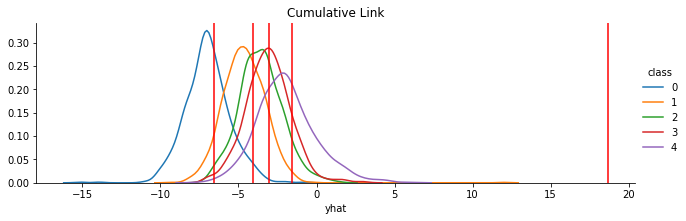

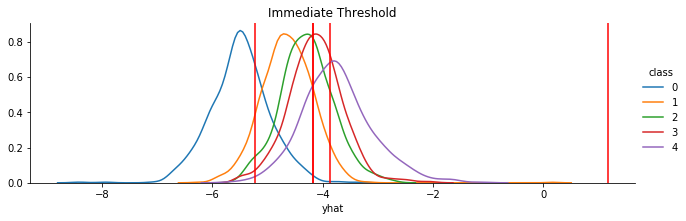

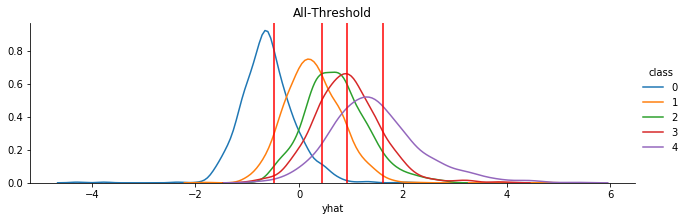

In [12]:
test_model = OrdinalModel(abalone_X, abalone_y, abalone_X, abalone_y)
test_model.adjust_and_scale()
test_model.fit('cumlink', 'logistic')
plot_thresh(test_model, 'Cumulative Link')
test_model.fit('thresh_IT')
plot_thresh(test_model, 'Immediate Threshold')
test_model.fit('thresh_AT')
plot_thresh(test_model, 'All-Threshold')

In [13]:
#Run 5-fold CV on all datasets and threshold methods
skf = StratifiedKFold(n_splits=5)
results_tbl = [] 
error = 'MAE'
for df in datasets:
    X=np.array(globals()[df+"_X"])
    y=np.array(globals()[df+"_y"])
    res_df = []
    for train_index, test_index in skf.split(X, y):
        df_model = OrdinalModel(X[train_index], y[train_index], X[test_index], y[test_index])
        df_model.adjust_and_scale()
        df_model.fit('cumlink','logistic')
        err_cll=df_model.MAE
        df_model.fit('cumlink', 'normal')
        err_cln=df_model.MAE
        df_model.fit('thresh_IT')
        err_it=df_model.MAE
        df_model.fit('thresh_AT')
        err_at=df_model.MAE
        res_df.append([err_cll, err_cln, err_it, err_at])
    results = pd.DataFrame(res_df).mean()
    results_tbl.append([round(val,3) for val in results])
results_thresh = pd.DataFrame(results_tbl, index=datasets, columns=['CL - Logit', 'CL - Probit', 
                                                                    'Imm. Thresh.', 'All Thresh.']).astype(float)
format_table(results_thresh)

,CL - Logit,CL - Probit,Imm. Thresh.,All Thresh.
abalone,0.683,0.686,0.75,0.67*
wwine,0.55,0.545,0.548,0.544*
rwine,0.45,0.443*,0.454,0.446
wiki,0.959,0.963,0.949*,0.951
wiki2,0.741,0.741,0.727*,0.734
wiki3,0.797,0.8,0.817,0.792*
boston,0.448,0.456,0.444*,0.464
syn,0.412*,0.747,0.414,0.412


# Neural Network (multi-label) Extension

A simple data change proposed by Cheng(2007) allows us to easy adapt ordianal problems to neural networks or other classifiers capable of multi-label predictions, like trees.  Instead of one-hot encoding of the categories (as done in the baseline here), now if a data point x belongs to category k, it is classified automatically into all of the lower-order categories (0, 1, ..., k−1) as well. So the target vector of x is t = (1, 1, .., 1, 0, 0, 0), where $t_{k}$ (1 ≤ i ≤ k) is set to 1 and other elements 0.  Then, instead of the general multiclass where the output nodes are softmax in order to give us a total probability of 1 across all classes - here we fit each output independently as a sigmoid.  We can then use the number of individual classes predicted to be greater than 0.5 as our overall predicted class.  It is worth noting that using independent sigmoid functions for output nodes does not guarantee the monotonic relation without further constraints.

As in general with models like this, the predictive performance is generally good, but it suffers from a lack of interpretablity.  Note for testing I use a very simple network with no optimization - but I look more at the relative difference between the ordinal and non-ordinal.

In [14]:
#Load keras libraries
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

# define baseline model and ordinal model
def baseline_model(input_dim, output_dim):
    # create model for multiclass
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['mae'])
    return model

def ordinal_model(input_dim, output_dim):
    # create model for binary (ordinal)
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['mae'])
    return model

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

Using TensorFlow backend.


In [15]:
def run_NN(model, ordinal):
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np.array(pd.get_dummies(model.y))
    X = model.X
    X_test = model.X_test
    #make dummies for ordinal
    new_dummy=dummy_y.copy()
    for i in range(len(model.y)):
        new_dummy[:,:model.y[i]]=1
    if (ordinal==True):
        estimator_ord = KerasClassifier(build_fn=ordinal_model, epochs=100, batch_size=32, 
                                    verbose=0, input_dim=X.shape[1], output_dim=model.k,
                                    validation_split=0.1, callbacks=callbacks)
        nn_fit_ord = estimator_ord.fit(X, new_dummy)        
        #predict individual
        pred_ord = nn_fit_ord.model.predict(X_test)
        model.pred_prob_y = pred_ord
        #predict overall class
        model.pred_y = pd.DataFrame(pred_ord>0.5).sum(axis=1)-1        
    else:    
        estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=32, 
                                verbose=0, input_dim=X.shape[1], output_dim=model.k, 
                                validation_split=0.1, callbacks=callbacks)
        nn_fit = estimator.fit(X, dummy_y)
        model.pred_y = nn_fit.model.predict_classes(X_test)
        model.pred_prob_y = nn_fit.model.predict(X_test)
    return 0

In [16]:
#Run 5-fold CV on all datasets and nn methods
skf = StratifiedKFold(n_splits=5)
results_tbl = [] 
error = 'MAE'
for df in datasets:
    X=np.array(globals()[df+"_X"])
    y=np.array(globals()[df+"_y"])
    res_df = []
    for train_index, test_index in skf.split(X, y):
        df_model = OrdinalModel(X[train_index], y[train_index], X[test_index], y[test_index])
        df_model.adjust_and_scale()
        df_model.fit('NN')
        err_nn=df_model.MAE
        df_model.fit('NN_ord')
        err_onn=df_model.MAE
        res_df.append([err_nn, err_onn])
    results = pd.DataFrame(res_df).mean()
    results_tbl.append([round(val,3) for val in results])
results_nn = pd.DataFrame(results_tbl, index=datasets, columns=['NN Multi', 'NN Ordinal']).astype(float)
format_table(results_nn)

,NN Multi,NN Ordinal
abalone,0.726*,0.728
wwine,0.523*,0.529
rwine,0.456,0.444*
wiki,0.86*,0.938
wiki2,0.78,0.766*
wiki3,0.866,0.855*
boston,0.657,0.6*
syn,0.499,0.464*


## Conclusions:

The final MAE scores for all datasets under each method using 5-fold CV is listed below as well.
I would say it's worth noticing that the ordinal threshold models perform very well across the board.  The all-threshold seems to be the best which I would have expected given it's closer ties to my error metric, MAE, but they were all generally good.  Given the additional interpretability, to me these are appealing choices, certainly in a linear space - and they do appear to add value over standard methods in data that can be considered ordinal.
For pure prediction, the ability to plug a robust model into either a binary deconstruction like the SVM example, or a multi-label NN or tree do have some appeal as a plug-and-play solution since there are so many available tools.  These methods are also no longer constrained to linear boundary seperations - which is obviously quite helpful in some of the data instances.  Currently in python there are no real libraries for ordinal threshold models - though R does have a few.

In [17]:
#combine all tables
results_all = pd.concat((results_base, results_thresh, results_nn), axis=1)
results_all.loc['mean'] = round(results_all.mean(),3)
display(data_summary.set_index('Dataset'))
display(format_table(results_all))

,Classes,# Samples,# Features,NMI
Dataset,,,,
abalone,5,4177,9,0.191370
wwine,7,4898,11,0.347499
rwine,6,1599,11,0.309211
wiki,5,871,11,0.154212
wiki2,5,871,11,0.151258
wiki3,5,871,11,0.154825
boston,5,506,13,0.418823
syn,5,1000,10,0.215155


,Logistic-Multi,Logistic-Ovr,LinReg Ord,Ordinal binary,Ord-Bin-SVM,CL - Logit,CL - Probit,Imm. Thresh.,All Thresh.,NN Multi,NN Ordinal
abalone,0.720,0.745,0.731,0.719,0.677,0.683,0.686,0.75,0.67*,0.726,0.728
wwine,0.540,0.541,0.546,0.545,0.525,0.550,0.545,0.548,0.544,0.523*,0.529
rwine,0.465,0.462,0.446,0.463,0.45,0.450,0.443*,0.454,0.446,0.456,0.444
wiki,1.012,1.020,0.937,1.012,0.9,0.959,0.963,0.949,0.951,0.86*,0.938
wiki2,0.781,0.777,0.741,0.783,0.761,0.741,0.741,0.727*,0.734,0.78,0.766
wiki3,0.826,0.824,0.798,0.823,0.811,0.797,0.8,0.817,0.792*,0.866,0.855
boston,0.538,0.637,0.518,0.520,0.612,0.448,0.456,0.444*,0.464,0.657,0.600
syn,0.415,0.463,0.444,0.406,0.351*,0.412,0.747,0.414,0.412,0.499,0.464
mean,0.662,0.684,0.645,0.659,0.636,0.630,0.673,0.638,0.627*,0.671,0.666


# References:

$\text {Agresti, A. } ( 2010 ) . \text { Analysis of Ordinal Categorical Data. Wiley, 2nd edition. }$

$\text {Cardoso, Jaime S. and Pinto da Costa, Joaquim F.  Learning to classify ordinal data: the data replication method} \\ \text {   In Journal of Machine Learning Research, volume 8, 2007}$

$ \text {Cheng, Jianlin. A Neural Network Approach to Ordinal Regression. School of Electrical Engineering and Computer Science. 2007.} $

$ \text {Wei Chu and S Sathiya Keerthi. New approaches to support vector ordinal regression. In }  \\ { \text { Proceedings of the } 22 \text {th} \text { International Conference on Machine Learning } ( I C M L ) , 2005 . } $

$\text {E. Frank and M. Hall. A simple approach to ordinal classification. In Procedings of the European } \\ { \text {   Conference on Machine Learning, pages } 145 - 165,2001 . }$

$\text {Ling Li and Hsuan-tien Lin. Ordinal regression by extended binary classification.} \\ \text {   In Advances in Neural Information Processing Systems (NIPS). MIT Press, 2007. } $

$\text {McCullagh, Peter. Regression models for ordinal data. Journal of the Royal Statistical } \\ { \text {   Society, } 1980 . } $

$\text {Irena Milstein, Arie Ben-David, Rob Potharst. Generating noisy monotone ordinal datasets.} \\ { \text { Artificial Intelligence Research 2014, Vol. 3, No. 1 } }$

$\text {Fabian Pedregosa, Francis Bach, Alexandre Gramfort. On the Consistency of Ordinal Regression} \\ { \text {   Methods. } 2015 . < \mathrm { hal } - 01054942 \mathrm { v } 3 > } $

$\text {Jason D. M. Rennie and Nathan Srebro. Loss functions for preference levels : Regression } \\ { \text {   with discrete ordered labels. In Proceedings of the IJCAI Multidisciplinary Workshop on } } \\ { \text {   Advances in Preference Handling, 2005. } } $

$\text {A. Shashua and A. Levin. Ranking with large margin principle: two approaches. In S. Thrun } \\ { \text {   S. Becker and K. Obermayer, editors, Advances in Neural Information Processing Systems } 15 , } \\ { \text {   pages } 937 - 944 . \text { MIT Press, } 2003 . }$